In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [32]:
# choose a list of 5 countries to start with abundant data
countries = ['India', 'Canada', 'Germany', 'Australia', 'Brazil']

In [33]:
def compute_percent_change_features(country_list, start_date, train_date, test_date):
    def percent_change(new, original):
        return (new - original) / original
    
    # store dataframes in lists
    df_list = []

    for country in countries:
        country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
        
        # check if there's no organizations, if so use number of occurences of country as backup
        for index, orgs in enumerate(country_df['Country Specific Orgs']):
            if orgs == 0:
                country_df.at[index, 'Country Specific Orgs'] = str(country_df.at[index, 'Addresses']).count(country)
        
        country_df = country_df.drop(columns=['Country Specific Authors'])
        country_df = country_df[country_df['Country Specific Orgs'] > 0]
        country_df = country_df.reset_index(drop=True)

        # get papers from 1998 and onwards
        country_df = country_df[country_df['Publication Year'] >= 1998]
        country_df = country_df.reset_index(drop=True)
        df_list.append(country_df)

    country_train = []
    country_test = []

    for country_data in df_list:
        train_data = pd.DataFrame(dict({'Year': np.zeros(train_date - 1998 + 1), 'Paper Volume': np.zeros(train_date - 1998 + 1), 'Mean Adj. Citations': np.zeros(train_date - 1998 + 1), 'Mean Orgs': np.zeros(train_date - 1998 + 1)}))
        test_data = pd.DataFrame(dict({'Year': np.zeros(test_date - train_date + 1), 'Paper Volume': np.zeros(test_date - train_date + 1), 'Mean Adj. Citations': np.zeros(test_date - train_date + 1), 'Mean Orgs': np.zeros(test_date - train_date + 1)}))
        for date in range(1998, test_date + 1):
            year_data = country_data[country_data['Publication Year'] == date]
            year_data = year_data.reset_index(drop=True)

            if date < train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            elif date == train_date:
                train_data.iloc[date - 1998] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]
            else:
                test_data.iloc[date - train_date] = [date, len(year_data), year_data['Adjusted Citations'].mean(), year_data['Country Specific Orgs'].mean()]

        country_train.append(train_data)
        country_test.append(test_data)
    
    protected_df = pd.read_csv('protected_land_cleaned.csv')
    
    # now compute the percent changes starting from start_date (i.e. can start analysis in start_date + 1)
    
    percent_change_train = []
    percent_change_test = []
    percent_change_protected_test = []
    percent_change_protected_train = []

    for train_df in country_train:
        percent_train = pd.DataFrame(dict({'Change Volume': np.zeros(train_date - start_date), 'Change Citations': np.zeros(train_date - start_date), 'Change Orgs': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            percent_train.iloc[i] = [percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Paper Volume'], train_df.iloc[start_date - 1998 + i]['Paper Volume']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Adj. Citations'], train_df.iloc[start_date - 1998 + i]['Mean Adj. Citations']), percent_change(train_df.iloc[start_date - 1998 + 1 + i]['Mean Orgs'], train_df.iloc[start_date - 1998 + i]['Mean Orgs'])]
        percent_change_train.append(percent_train)

    for test_df in country_test:    
        percent_test = pd.DataFrame(dict({'Change Volume': np.zeros(test_date - train_date), 'Change Citations': np.zeros(test_date - train_date), 'Change Orgs': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            percent_test.iloc[i] = [percent_change(test_df.iloc[1 + i]['Paper Volume'], test_df.iloc[i]['Paper Volume']), percent_change(test_df.iloc[1 + i]['Mean Adj. Citations'], test_df.iloc[i]['Mean Adj. Citations']), percent_change(test_df.iloc[1 + i]['Mean Orgs'], test_df.iloc[i]['Mean Orgs'])]
        percent_change_test.append(percent_test)

    for country in countries:
        country_protected = protected_df[protected_df['Country'] == country]
        country_protected = country_protected[country_protected['Year'] >= start_date]
        country_protected = country_protected[country_protected['Year'] <= test_date]
        country_protected = country_protected.reset_index(drop=True)

        protect_change_train = pd.DataFrame(dict({'Change Protected Percent': np.zeros(train_date - start_date)}))
        for i in range(train_date - start_date):
            protect_change_train.iloc[i] = [percent_change(country_protected.iloc[1 + i]['Value'], country_protected.iloc[0 + i]['Value'])]
        percent_change_protected_train.append(protect_change_train)

        protect_change_test = pd.DataFrame(dict({'Change Protected Percent': np.zeros(test_date - train_date)}))
        for i in range(test_date - train_date):
            protect_change_test.iloc[i] = [percent_change(country_protected.iloc[train_date - start_date + 1 + i]['Value'], country_protected.iloc[train_date - start_date + i]['Value'])]
        percent_change_protected_test.append(protect_change_test)
        
    return percent_change_train, percent_change_test, percent_change_protected_train, percent_change_protected_test

In [34]:
X_train_list, X_test_list, y_train_list, y_test_list = compute_percent_change_features(countries, 2000, 2016, 2021)

C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (11,15,50,52) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [35]:
X_train_list[0]

,Change Volume,Change Citations,Change Orgs
0,0.000000,4.344687,-0.019231
1,0.181818,-0.587581,-0.021116
2,0.256410,-0.213376,0.079211
3,0.020408,0.514996,0.041250
4,1.060000,-0.163923,0.039406
5,-0.320388,0.255967,0.034851
6,0.357143,-0.082797,-0.084704
7,0.305263,-0.018457,-0.224234
8,0.274194,-0.275557,-0.073827
9,0.303797,1.744315,0.073786


In [36]:
X_test_list[0]

,Change Volume,Change Citations,Change Orgs
0,0.429508,0.056383,0.077294
1,0.064220,-0.257416,-0.022209
2,0.133621,0.038314,0.176631
3,0.176806,-0.313062,-0.025015
4,0.216478,-0.749899,0.016453


In [37]:
def calc_MSE(y_pred, y_true):
    return (1/len(y_pred))*sum(((np.array(y_pred)-np.array(y_true))**2))[0]

In [38]:
# build a simple Linear Regression Model for Country 0 (Australia)

regr = LinearRegression()
regr = regr.fit(X_train_list[0], y_train_list[0])

# get MSE on the test set
calc_MSE(regr.predict(X_test_list[0]), y_test_list[0])

0.0026548272352833187

In [39]:
regr.predict(X_test_list[3])

array([[0.05131317],
       [0.05197157],
       [0.05115101],
       [0.05218497],
       [0.05782366]])

In [40]:
y_test_list[3]

,Change Protected Percent
0,0.013382
1,0.005280
2,0.000147
3,0.049414
4,0.000000


In [41]:
regr.coef_[0]

array([ 0.00903021, -0.01220058, -0.07615483])

In [42]:
from sklearn.preprocessing import PolynomialFeatures

# choose polynomial order than minimizes MSE on test set
degrees = list(range(1, 11))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_list[1])
    X_poly_test = poly.transform(X_test_list[1])

    # fit a model with the new polynomial features
    poly_regr = LinearRegression()
    poly_regr = poly_regr.fit(X_poly_train, y_train_list[1])

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_test_list[1])}')

MSE of Degree 1 polynomial: 0.0002431015541504423
MSE of Degree 2 polynomial: 0.0016286612558668986
MSE of Degree 3 polynomial: 0.029645688682991556
MSE of Degree 4 polynomial: 0.00849295062827366
MSE of Degree 5 polynomial: 0.013519879530212798
MSE of Degree 6 polynomial: 0.010853423043150094
MSE of Degree 7 polynomial: 0.012203811433280087
MSE of Degree 8 polynomial: 0.011433054379523959
MSE of Degree 9 polynomial: 0.011792801209663228
MSE of Degree 10 polynomial: 0.011543621236261223


In [43]:
def shift_data(shift, X_train_list, X_test_list, y_train_list, y_test_list):
    X_shifted_train_list = []
    X_shifted_test_list = []
    y_shifted_train_list = []
    y_shifted_test_list = []
    
    for index, df in enumerate(X_train_list):
        X_shifted = X_train_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_train_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change Volume Prev {shift_i + 1}', f'Change Citations Prev {shift_i + 1}', f'Change Orgs Prev {shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_train_list.append(X_shifted)
        y_shifted_train_list.append(y_train_list[index][shift:])
    
    for index, df in enumerate(X_test_list):
        X_shifted = X_test_list[index]
        for shift_i in range(shift):
            X_shifted_temp = X_test_list[index].shift(shift_i + 1)
            X_shifted_temp.columns = [f'Change Volume Prev {shift_i + 1}', f'Change Citations Prev {shift_i + 1}', f'Change Orgs Prev {shift_i + 1}']
            X_shifted = pd.concat([X_shifted, X_shifted_temp], axis=1)
        X_shifted = X_shifted.dropna()
        X_shifted_test_list.append(X_shifted)
        y_shifted_test_list.append(y_test_list[index][shift:])
    
    return X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list

In [44]:
X_shifted_train_list, X_shifted_test_list, y_shifted_train_list, y_shifted_test_list = shift_data(3, X_train_list, X_test_list, y_train_list, y_test_list)

In [45]:
# Ridge and Lasso Regression on shifted data
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

ridge_regr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])
lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100]).fit(X_shifted_train_list[0], y_shifted_train_list[0])

# get MSE on the test set
print(f'Ridge MSE: {calc_MSE(ridge_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')
print(f'Lasso MSE: {calc_MSE(lasso_regr.predict(X_shifted_test_list[0]), y_shifted_test_list[0])}')


Ridge MSE: 0.0017454703777258999
Lasso MSE: 0.0016848298201047962


C:\Users\freja\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1100: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [46]:
degrees = list(range(1, 5))

for degree in degrees:
    # polynomial feature transform
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_shifted_train_list[0])
    X_poly_test = poly.transform(X_shifted_test_list[0])

    # fit a model with the new polynomial features
    poly_regr = LassoCV(alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], max_iter=100000)
    poly_regr = poly_regr.fit(X_poly_train, np.ravel(y_shifted_train_list[0]))

    # get MSE on test set
    print(f'MSE of Degree {degree} polynomial: {calc_MSE(poly_regr.predict(X_poly_test), y_shifted_test_list[0])}')

MSE of Degree 1 polynomial: 0.0016848298201047962


C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

MSE of Degree 2 polynomial: 0.00016424742846294168
MSE of Degree 3 polynomial: 0.00011464090987809995
MSE of Degree 4 polynomial: 0.0004984252318457975


In [47]:
poly_regr.coef_

array([ 0.,  0., -0., ..., -0., -0., -0.])

In [48]:
ridge_regr.coef_[0]

array([ 1.45396721e-04,  2.56862269e-04, -2.82414947e-05, -1.12198677e-03,
       -2.31251759e-03, -4.29865240e-05,  4.26657828e-04,  6.42217352e-03,
        3.50706661e-04,  2.60446512e-05, -2.69672009e-03, -2.31021531e-04])

In [49]:
lasso_regr.predict(X_shifted_test_list[3])

array([0.04104668, 0.04104668])

In [50]:
X_shifted_train_list[0]

,Change Volume,Change Citations,Change Orgs,Change Volume Prev 1,Change Citations Prev 1,Change Orgs Prev 1,Change Volume Prev 2,Change Citations Prev 2,Change Orgs Prev 2,Change Volume Prev 3,Change Citations Prev 3,Change Orgs Prev 3
3,0.020408,0.514996,0.041250,0.256410,-0.213376,0.079211,0.181818,-0.587581,-0.021116,0.000000,4.344687,-0.019231
4,1.060000,-0.163923,0.039406,0.020408,0.514996,0.041250,0.256410,-0.213376,0.079211,0.181818,-0.587581,-0.021116
5,-0.320388,0.255967,0.034851,1.060000,-0.163923,0.039406,0.020408,0.514996,0.041250,0.256410,-0.213376,0.079211
6,0.357143,-0.082797,-0.084704,-0.320388,0.255967,0.034851,1.060000,-0.163923,0.039406,0.020408,0.514996,0.041250
7,0.305263,-0.018457,-0.224234,0.357143,-0.082797,-0.084704,-0.320388,0.255967,0.034851,1.060000,-0.163923,0.039406
8,0.274194,-0.275557,-0.073827,0.305263,-0.018457,-0.224234,0.357143,-0.082797,-0.084704,-0.320388,0.255967,0.034851
9,0.303797,1.744315,0.073786,0.274194,-0.275557,-0.073827,0.305263,-0.018457,-0.224234,0.357143,-0.082797,-0.084704
10,-0.024272,-0.459643,-0.029065,0.303797,1.744315,0.073786,0.274194,-0.275557,-0.073827,0.305263,-0.018457,-0.224234
11,0.233831,0.291305,-0.022273,-0.024272,-0.459643,-0.029065,0.303797,1.744315,0.073786,0.274194,-0.275557,-0.073827
12,-0.133065,0.330625,0.051040,0.233831,0.291305,-0.022273,-0.024272,-0.459643,-0.029065,0.303797,1.744315,0.073786


In [51]:
# run lasso regression over each country, compute the mean model and then measure performance

coef_df = pd.DataFrame(dict({'Coef_1': np.zeros(len(X_shifted_train_list)), 'Coef_2': np.zeros(len(X_shifted_train_list)),
                            'Coef_3': np.zeros(len(X_shifted_train_list)), 'Coef_4': np.zeros(len(X_shifted_train_list)),
                            'Coef_5': np.zeros(len(X_shifted_train_list)), 'Coef_6': np.zeros(len(X_shifted_train_list)),
                            'Coef_7': np.zeros(len(X_shifted_train_list)), 'Coef_8': np.zeros(len(X_shifted_train_list)),
                            'Coef_9': np.zeros(len(X_shifted_train_list)), 'Coef_10': np.zeros(len(X_shifted_train_list)),
                            'Coef_11': np.zeros(len(X_shifted_train_list)), 'Coef_12': np.zeros(len(X_shifted_train_list)),
                            'intercept': np.zeros(len(X_shifted_train_list))}))

for i in range(len(X_shifted_train_list)):
    lasso_regr = LassoCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], max_iter=100000).fit(X_shifted_train_list[i], np.ravel(y_shifted_train_list[i]))
    coef_df.iloc[i] = [lasso_regr.coef_[0], lasso_regr.coef_[1], lasso_regr.coef_[2], lasso_regr.coef_[3],
                      lasso_regr.coef_[4], lasso_regr.coef_[5], lasso_regr.coef_[6], lasso_regr.coef_[7],
                      lasso_regr.coef_[8], lasso_regr.coef_[9], lasso_regr.coef_[10], lasso_regr.coef_[11],
                      lasso_regr.intercept_]

coef_df.mean()

C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\freja\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

Coef_1       0.000000
Coef_2       0.030515
Coef_3       0.000000
Coef_4       0.020371
Coef_5       0.012953
Coef_6       0.000000
Coef_7       0.000446
Coef_8       0.009606
Coef_9       0.000000
Coef_10      0.000000
Coef_11      0.002489
Coef_12      0.000000
intercept    0.026865
dtype: float64

In [52]:
def linear_pred(mean_coefs, X_shifted_test):
    pred = 0
    for index, coef in enumerate(mean_coefs):
        if index < len(mean_coefs) - 1:
            pred += coef * X_shifted_test[index]
        else:
            # intercept
            pred += coef
    return pred

In [53]:
# test performance of mean model, calculating MSE for each country
for i in range(len(X_shifted_test_list)):
    preds = [linear_pred(np.array(coef_df.mean()), X_shifted_test_list[i].iloc[index]) for index in range(len(X_shifted_test_list[i]))]
    print(f'MSE for {countries[i]} is {calc_MSE(preds, y_shifted_test_list[i])}')

MSE for India is 0.0003321888790346846
MSE for Canada is 0.00019699057119864011
MSE for Germany is 0.0001278946879570806
MSE for Australia is 0.0007799753855141315
MSE for Brazil is 0.0002300009037210088


In [54]:
protected_df = pd.read_csv('protected_land_cleaned.csv')
for country in protected_df['Country'].unique():
    country_df = pd.read_csv(f'{country}_biodiversity_research.csv')
    print(f'{country}: {len(country_df)}')

Australia: 11732


C:\Users\freja\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


FileNotFoundError: [Errno 2] File b'Austria_biodiversity_research.csv' does not exist: b'Austria_biodiversity_research.csv'

## Correlation matrix

In [70]:
import seaborn as sb
import matplotlib.pyplot as plt

# gets list of correlation matrices for list of X data
def get_corr_matrices(X_train_lst):
    
    corr_matrices = []
    
    for X_train in X_train_lst:
        corr_matrices.append(X_train.corr().round(3))
        
    return corr_matrices

# plots the correlation matrix for one country
def plot_corr_matrix(corr_matrix):

    mask = np.triu(np.ones_like(corr_matrix))
 
    dataplot = sb.heatmap(corr_matrix,vmax=1, vmin=-1, cmap=sb.diverging_palette(20, 220, n=200),  mask=mask)

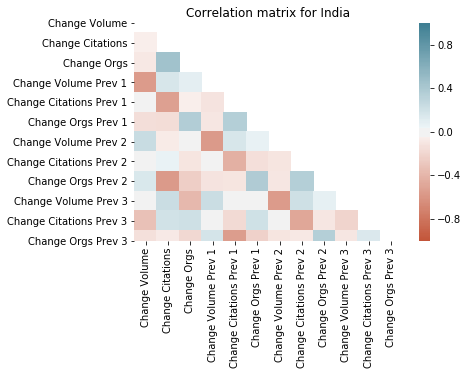

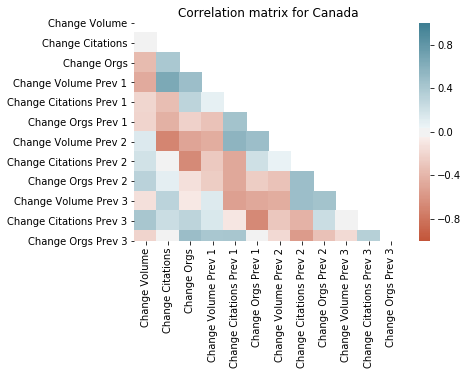

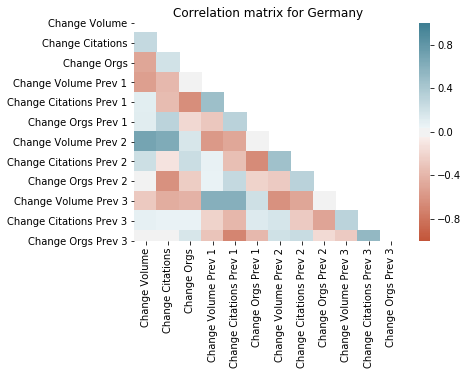

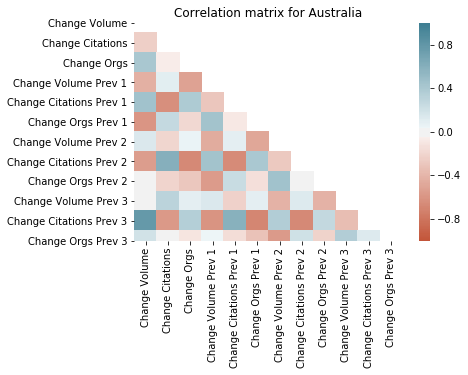

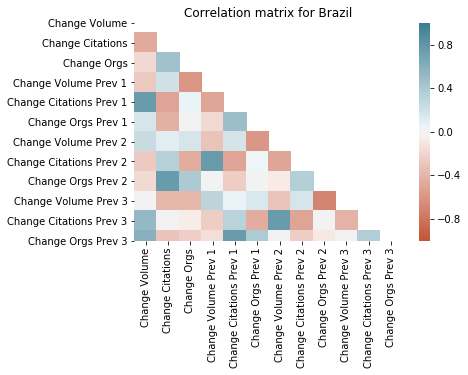

In [106]:
corr_matrices_shifted_data = get_corr_matrices(X_shifted_train_list)


for i in range(0, len(countries)):
    plt.title(f"Correlation matrix for {countries[i]}")
    plot_corr_matrix(corr_matrices_shifted_data[i])
    plt.show()


#sb.pairplot(X_shifted_train_list[0])

## Granger Causality Test

In [115]:
from statsmodels.tsa.stattools import grangercausalitytests

def get_granger_causality(response, max_lag, X_train_data, y_train_data):

    stat_test_names = ['ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest']

    # creating dataframe with all features and response variable
    df = X_train_data
    features_list = df.columns
    df[response] = y_train_data


    # dataframe to hold final results
    df_p_stat = pd.DataFrame()

    
    # have to run the causality test separately for each feature
    for feature in features_list:

        granger_causality = grangercausalitytests(df[[response, feature]], maxlag=max_lag, verbose=False)

        # array to hold relevant p statistic values
        p_stat_array = []

        # getting the p-values for each lag time and stat. test
        for lag in range(1, max_lag+1):
            p_vals = []
            for test_name in stat_test_names:
                p_vals.append(granger_causality[lag][0][test_name][1])

            # checking if any of the p_values are lower than 0.05 (i.e. significant)
            min_p = min(p_vals)
            # if so, add it to the array, if not, fill in with NaN value
            if min_p < 0.05:
                p_stat_array.append(min_p)
            else:
                p_stat_array.append(np.nan)

        df_p_stat[feature] = p_stat_array

    return df_p_stat    

In [128]:
response = "Change Protected Percent"
max_lag = 4
feature_list = ['Change Volume', 'Change Citations', 'Change Orgs']

# granger causality test for different countries
granger_casuality_test = []

for i in range(0, len(countries)):
    granger_casuality_test.append(get_granger_causality(response, max_lag, X_train_list[i], y_train_list[i]))

Plotting granger causality test results

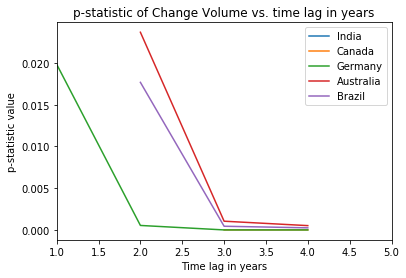

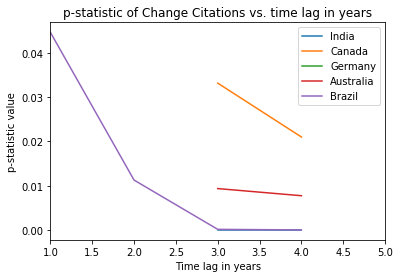

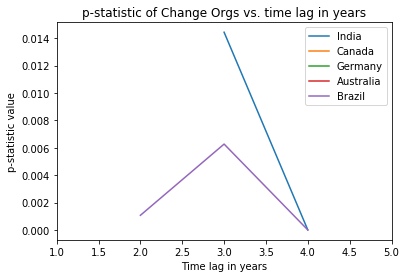

In [129]:
time_lag = np.arange(1, max_lag+1)

for feature in feature_list:
    for i in range(0, len(countries)):
        plt.plot(time_lag, granger_casuality_test[i][feature], label=countries[i])

    plt.title(f"p-statistic of {feature} vs. time lag in years")
    plt.xlim([1, max_lag+1])
    plt.xlabel("Time lag in years")
    plt.ylabel("p-statistic value")
    plt.legend()
    plt.show()